<a href="https://colab.research.google.com/github/visheshchandrakar/Price-Optimization/blob/main/Price_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

pricing_data = pd.read_csv("Competition_Data.csv")

print(pricing_data.head())

   Index Fiscal_Week_ID   Store_ID   Item_ID   Price  Item_Quantity  \
0      0        2019-11  store_459  item_526  134.49            435   
1      1        2019-11  store_459  item_526  134.49            435   
2      2        2019-11  store_459  item_526  134.49            435   
3      3        2019-11  store_459  item_526  134.49            435   
4      4        2019-11  store_459  item_526  134.49            435   

   Sales_Amount_No_Discount  Sales_Amount  Competition_Price  
0                   4716.74      11272.59             206.44  
1                   4716.74      11272.59             158.01  
2                   4716.74      11272.59             278.03  
3                   4716.74      11272.59             222.66  
4                   4716.74      11272.59             195.32  


In [2]:
pricing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Index                     100000 non-null  int64  
 1   Fiscal_Week_ID            100000 non-null  object 
 2   Store_ID                  100000 non-null  object 
 3   Item_ID                   100000 non-null  object 
 4   Price                     100000 non-null  float64
 5   Item_Quantity             100000 non-null  int64  
 6   Sales_Amount_No_Discount  100000 non-null  float64
 7   Sales_Amount              100000 non-null  float64
 8   Competition_Price         100000 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 6.9+ MB


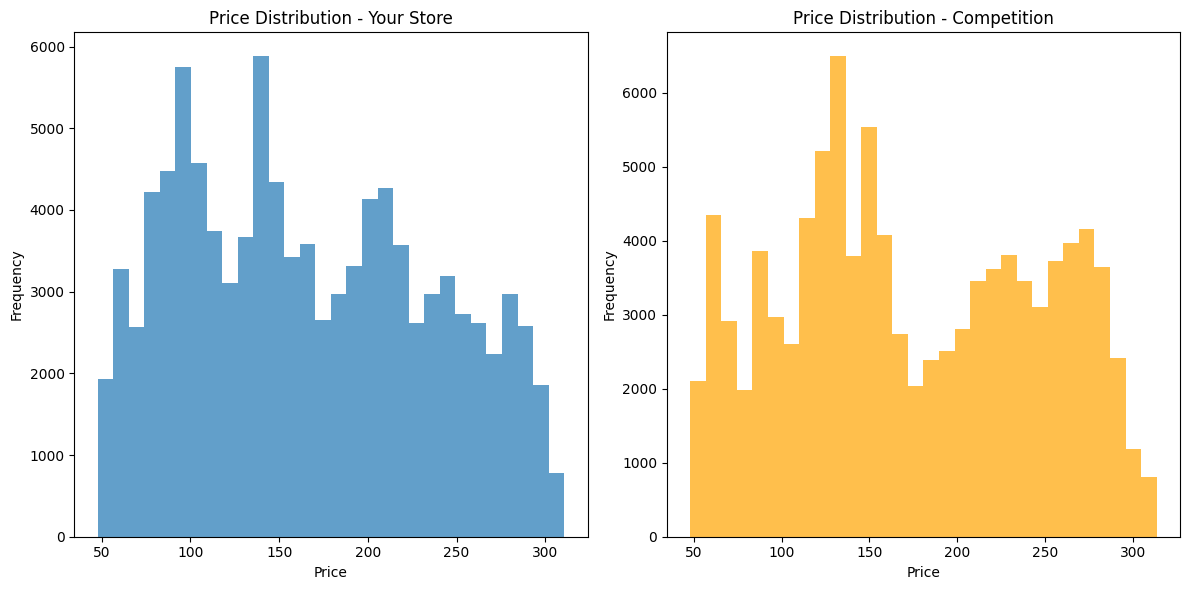

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(pricing_data['Price'], bins=30, alpha=0.7, label='Your Store')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution - Your Store')

plt.subplot(1, 2, 2)
plt.hist(pricing_data['Competition_Price'], bins=30, alpha=0.7, color='orange', label='Competition')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution - Competition')

plt.tight_layout()
plt.show()

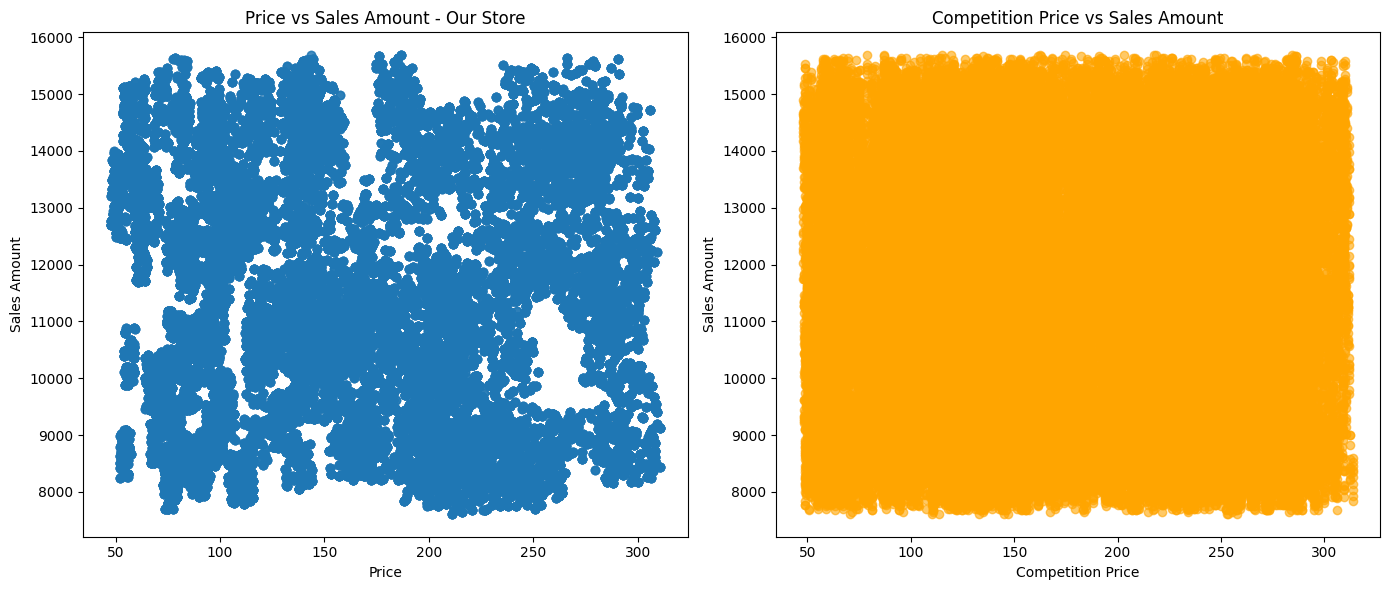

In [4]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(pricing_data['Price'], pricing_data['Sales_Amount'], alpha=0.6, label='Your Store')
plt.xlabel('Price')
plt.ylabel('Sales Amount')
plt.title('Price vs Sales Amount - Our Store')

plt.subplot(1, 2, 2)
plt.scatter(pricing_data['Competition_Price'], pricing_data['Sales_Amount'], alpha=0.6, color='orange', label='Competition')
plt.xlabel('Competition Price')
plt.ylabel('Sales Amount')
plt.title('Competition Price vs Sales Amount')

plt.tight_layout()
plt.show()

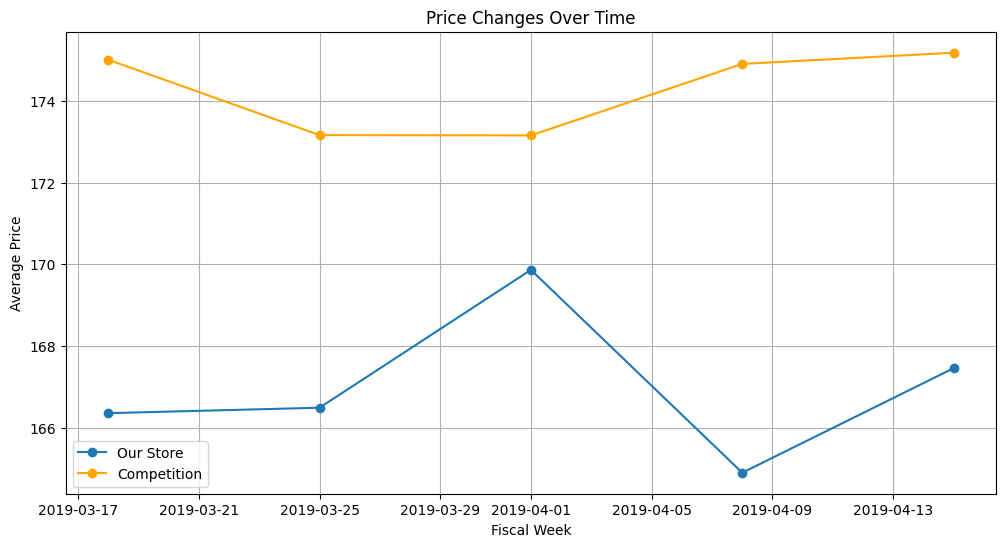

In [5]:
pricing_data['Fiscal_Week_ID'] = pd.to_datetime(pricing_data['Fiscal_Week_ID'] + '-1', format='%Y-%U-%w')

weekly_prices = pricing_data.groupby('Fiscal_Week_ID').agg({
    'Price': 'mean',
    'Competition_Price': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))

plt.plot(weekly_prices['Fiscal_Week_ID'], weekly_prices['Price'], label='Our Store', marker='o')
plt.plot(weekly_prices['Fiscal_Week_ID'], weekly_prices['Competition_Price'], label='Competition', marker='o', color='orange')

plt.xlabel('Fiscal Week')
plt.ylabel('Average Price')
plt.title('Price Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

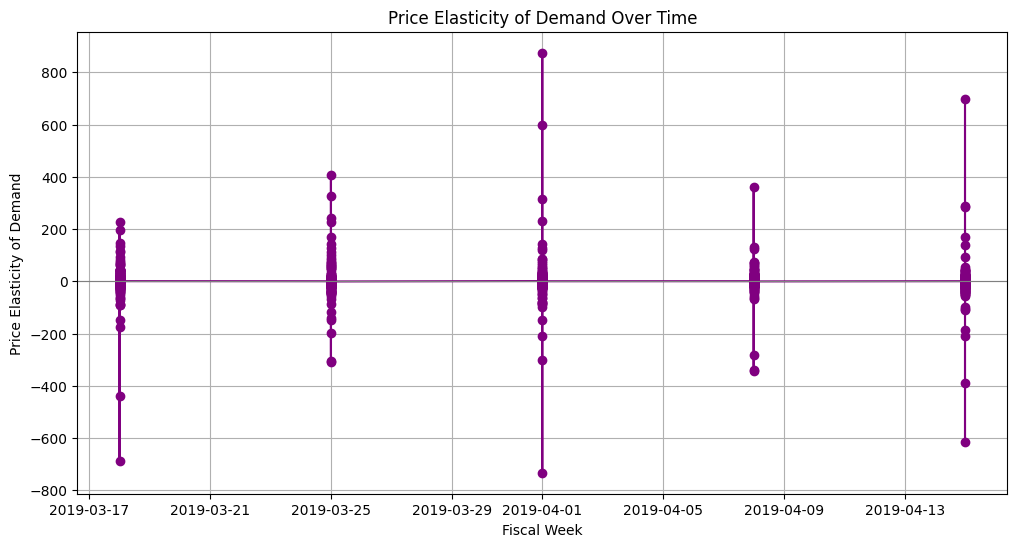

In [6]:
pricing_data['price_change'] = pricing_data['Price'].pct_change()
pricing_data['qty_change'] = pricing_data['Item_Quantity'].pct_change()

pricing_data['elasticity'] = pricing_data['qty_change'] / pricing_data['price_change']

pricing_data.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
pricing_data.dropna(subset=['elasticity'], inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(pricing_data['Fiscal_Week_ID'], pricing_data['elasticity'], marker='o', linestyle='-', color='purple')
plt.axhline(0, color='grey', linewidth=0.8)
plt.xlabel('Fiscal Week')
plt.ylabel('Price Elasticity of Demand')
plt.title('Price Elasticity of Demand Over Time')
plt.grid(True)
plt.show()

In [7]:
total_sales_your_store = pricing_data['Sales_Amount'].sum()
total_sales_competition = (pricing_data['Competition_Price'] * pricing_data['Item_Quantity']).sum()

total_qty_your_store = pricing_data['Item_Quantity'].sum()
total_qty_competition = pricing_data['Item_Quantity'].sum()  # assuming quantities sold are the same for comparison

summary = pd.DataFrame({
    'Metric': ['Total Sales Amount', 'Total Quantity Sold'],
    'Your Store': [total_sales_your_store, total_qty_your_store],
    'Competition': [total_sales_competition, total_qty_competition]
})


summary

,Metric,Your Store,Competition
0,Total Sales Amount,1.141005e+08,6.962097e+08
1,Total Quantity Sold,3.984776e+06,3.984776e+06


In [8]:
# define price brackets
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
labels = ['0-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350', '351-400', '401-450', '451-500']

# create price brackets for both your store and competition
pricing_data['price_bracket'] = pd.cut(pricing_data['Price'], bins=bins, labels=labels, right=False)
pricing_data['competition_price_bracket'] = pd.cut(pricing_data['Competition_Price'], bins=bins, labels=labels, right=False)

# calculate sales amount by price bracket for your store
sales_by_bracket_your_store = pricing_data.groupby('price_bracket')['Sales_Amount'].sum().reset_index()
sales_by_bracket_your_store.columns = ['Price Bracket', 'Your Store Sales Amount']

# calculate sales amount by price bracket for competition
pricing_data['competition_sales_amt'] = pricing_data['Competition_Price'] * pricing_data['Item_Quantity']
sales_by_bracket_competition = pricing_data.groupby('competition_price_bracket')['competition_sales_amt'].sum().reset_index()
sales_by_bracket_competition.columns = ['Price Bracket', 'Competition Sales Amount']

sales_by_bracket = pd.merge(sales_by_bracket_your_store, sales_by_bracket_competition, on='Price Bracket')

sales_by_bracket

<ipython-input-8-ee0556d4cf8d>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_bracket_your_store = pricing_data.groupby('price_bracket')['Sales_Amount'].sum().reset_index()
<ipython-input-8-ee0556d4cf8d>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_bracket_competition = pricing_data.groupby('competition_price_bracket')['competition_sales_amt'].sum().reset_index()


,Price Bracket,Your Store Sales Amount,Competition Sales Amount
0,0-50,346800.63,9.305357e+05
1,51-100,24636244.30,4.889277e+07
2,101-150,29645669.06,1.278404e+08
3,151-200,20658418.18,1.092184e+08
4,201-250,20742288.10,1.909748e+08
5,251-300,16778087.66,2.047670e+08
6,301-350,1292959.36,1.358583e+07
7,351-400,0.00,0.000000e+00
8,401-450,0.00,0.000000e+00
9,451-500,0.00,0.000000e+00


In [9]:
# segment customers based on purchasing behavior

# calculate average price and total quantity sold for each item
item_summary = pricing_data.groupby('Item_ID').agg({
    'Price': 'mean',
    'Item_Quantity': 'sum'
}).reset_index()

# merge the item summary back to the main dataset
pricing_data = pd.merge(pricing_data, item_summary, on='Item_ID', suffixes=('', '_avg'))

# define segments based on average price
pricing_data['segment'] = pd.cut(pricing_data['Price_avg'], bins=[0, 50, 150, 300], labels=['Low', 'Medium', 'High'])

# calculate price elasticity for each segment
segments = pricing_data['segment'].unique()
elasticity_data = []

for segment in segments:
    segment_data = pricing_data[pricing_data['segment'] == segment]
    segment_data['price_change'] = segment_data['Price'].pct_change()
    segment_data['qty_change'] = segment_data['Item_Quantity'].pct_change()
    segment_data['elasticity'] = segment_data['qty_change'] / segment_data['price_change']
    segment_data.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
    avg_elasticity = segment_data['elasticity'].mean()
    elasticity_data.append({'segment': segment, 'avg_elasticity': avg_elasticity})

elasticity_df = pd.DataFrame(elasticity_data)

elasticity_df

<ipython-input-9-aa9d22bf51c3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data['price_change'] = segment_data['Price'].pct_change()
<ipython-input-9-aa9d22bf51c3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data['qty_change'] = segment_data['Item_Quantity'].pct_change()
<ipython-input-9-aa9d22bf51c3>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,segment,avg_elasticity
0,Medium,0.154444
1,High,0.148043


In [10]:
# create a copy of the dataset for simulation
dynamic_pricing_data = pricing_data.copy()

# apply dynamic pricing rules
dynamic_pricing_data.loc[dynamic_pricing_data['segment'] == 'Medium', 'dynamic_price'] = dynamic_pricing_data['Price'] * 1.05
dynamic_pricing_data.loc[dynamic_pricing_data['segment'] == 'High', 'dynamic_price'] = dynamic_pricing_data['Price'] * 0.90

# calculate new sales amounts based on dynamic prices
dynamic_pricing_data['dynamic_sales_amt'] = dynamic_pricing_data['dynamic_price'] * dynamic_pricing_data['Item_Quantity']

# compare total sales amount between existing and dynamic pricing
total_sales_existing = pricing_data['Sales_Amount'].sum()
total_sales_dynamic = dynamic_pricing_data['dynamic_sales_amt'].sum()

# compare total quantity sold between existing and dynamic pricing
total_qty_existing = pricing_data['Item_Quantity'].sum()
total_qty_dynamic = dynamic_pricing_data['Item_Quantity'].sum()  # quantity sold remains the same for comparison

comparison_summary = pd.DataFrame({
    'Metric': ['Total Sales Amount', 'Total Quantity Sold'],
    'Existing Pricing': [total_sales_existing, total_qty_existing],
    'Dynamic Pricing': [total_sales_dynamic, total_qty_dynamic]
})

comparison_summary

,Metric,Existing Pricing,Dynamic Pricing
0,Total Sales Amount,1.141005e+08,6.226950e+08
1,Total Quantity Sold,3.984776e+06,3.984776e+06


In [11]:
pricing_data['dynamic_price'] = dynamic_pricing_data['dynamic_price']